In [1]:
# --- Step 1: Imports ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

In [2]:
# --- Step 2: Build feature extractor (MobileNetV2) ---
# Using include_top=False and a global average pooling to get a compact feature vector
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
model = Model(inputs=base_model.input, outputs=x)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [20]:
# --- Step 3: Feature extraction helper ---
def extract_features(img_path, model=model, target_size=(224,224)):
    """Load image, preprocess, extract feature vector (1D numpy array)."""
    img = load_img(img_path, target_size=target_size)
    arr = img_to_array(img)
    arr = np.expand_dims(arr, axis=0)
    arr = preprocess_input(arr)
    features = model.predict(arr, verbose=0)  # shape (1, D)
    return features.flatten()

In [22]:
folder_path = r"/content/similar images/similar images"   # <-- change to your folder
valid_ext = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')
filenames = sorted([os.path.join(folder_path, f) for f in os.listdir(folder_path)
                    if f.lower().endswith(valid_ext)])

if len(filenames) == 0:
    raise RuntimeError(f"No images found in {folder_path}. Check the path and extensions.")

# Extract and normalize features
features_list = []
print("Extracting features from folder images...")
for fn in filenames:
    feats = extract_features(fn)
    features_list.append(feats)
features_list = np.array(features_list)               # shape (N, D)
features_list = normalize(features_list, axis=1)     # L2-normalize each vector
print(f"Done. Extracted and normalized features for {len(filenames)} images.")

Extracting features from folder images...
Done. Extracted and normalized features for 490 images.


In [23]:
import zipfile

zip_path = '/content/similar images.zip'
extract_path = '/content/similar images/similar images'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Zip file extracted to: {extract_path}")

Zip file extracted to: /content/similar images/similar images


In [24]:
# --- Step 5: Find and display similar images for a NEW image (with scores) ---
def find_similar_for_new_image(new_image_path, top_n=5, show_scores=True):
    """
    Given a new image path, compute similarity to folder images and display top_n results.
    show_scores controls whether similarity % is shown under each result.
    """
    if not os.path.exists(new_image_path):
        raise FileNotFoundError(f"Query image not found: {new_image_path}")

    # Extract and normalize new image features
    new_feats = extract_features(new_image_path).reshape(1, -1)
    new_feats = normalize(new_feats, axis=1)

    # Cosine similarities
    sims = cosine_similarity(new_feats, features_list)[0]  # shape (N,)

    # Get top indices sorted by similarity desc
    top_idx = sims.argsort()[::-1][:top_n]
    top_scores = sims[top_idx]

    # Plot query + top matches
    plt.figure(figsize=(3*(top_n+1), 4))

    # Query image on left
    plt.subplot(1, top_n+1, 1)
    plt.imshow(load_img(new_image_path))
    plt.title("Query")
    plt.axis("off")

    # Show top matches
    for i, idx in enumerate(top_idx):
        plt.subplot(1, top_n+1, i+2)
        plt.imshow(load_img(filenames[idx]))
        if show_scores:
            score_pct = top_scores[i] * 100.0
            plt.title(f"{score_pct:.2f}%")
        else:
            plt.title(f"Rank {i+1}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

    # Also return a small structured result
    results = [{"filename": filenames[idx], "score": float(top_scores[i])} for i, idx in enumerate(top_idx)]
    return results

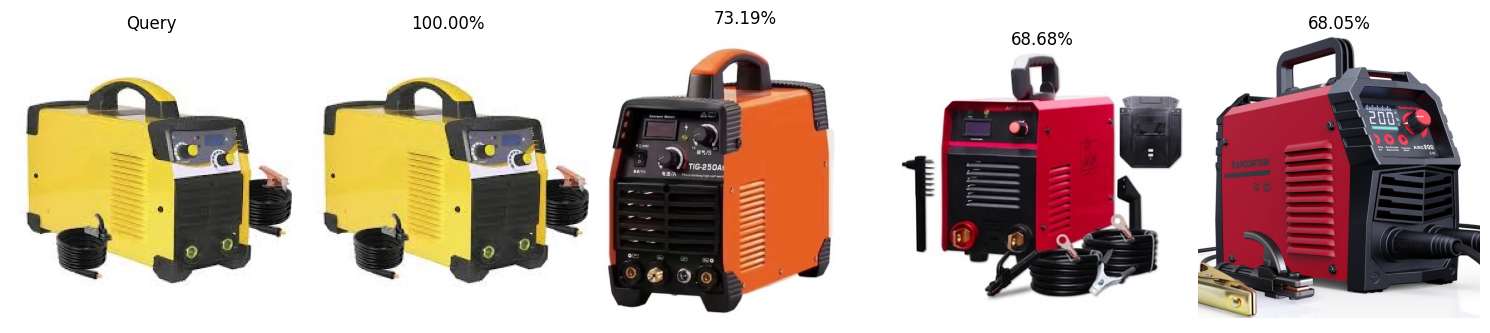

In [27]:
# --- Step 6: Example usage ---
new_image_path = r"/content/similar images/similar images/IMG-20250910-WA0007.jpg"   # <-- Change to your newly taken image path
top_results = find_similar_for_new_image(new_image_path, top_n=4)